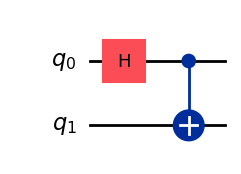

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0 , 1)

qc.draw(output = 'mpl')

In [2]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli("XI")
IX = Pauli("IX")

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [3]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.00976562,  0.00976562,  1.        , -0.05664062,
       -0.05664062]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0035359, 'sample_measure_time': 0.0009537, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 32684, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999046325683594, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0035359, 'sample_measure_time': 0.0009

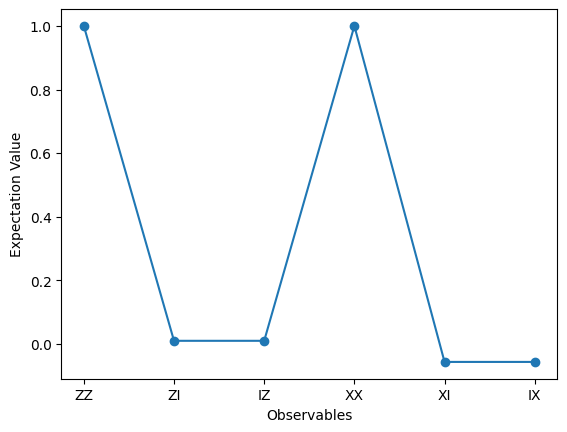

In [4]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation Value')
plt.show()

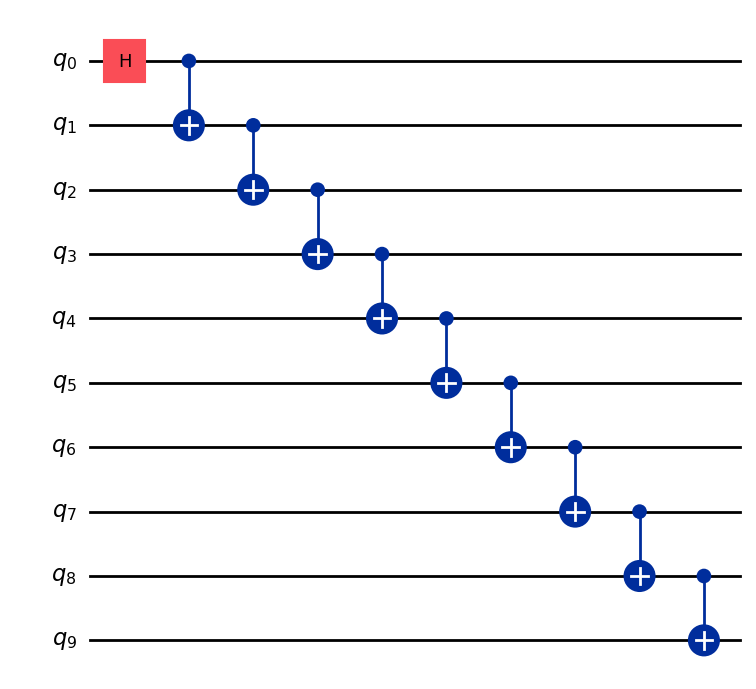

In [5]:
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range (n-1):
        qc.cx(i, i+1)
    return qc

n = 10
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output='mpl')

In [6]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z'+ 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]


['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService(channel="ibm_quantum", token="c9e67968380edbf2586516990355fab9df9a1126982ab07d843f863c67e2c25ab70122e365861df05903cede565dfeb86688340a5b49cf67219171f44ee1ecda").get_backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend = backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

C:\Users\Himank\AppData\Local\Temp\ipykernel_1722284\2477581601.py:5: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = QiskitRuntimeService(channel="ibm_quantum", token="c9e67968380edbf2586516990355fab9df9a1126982ab07d843f863c67e2c25ab70122e365861df05903cede565dfeb86688340a5b49cf67219171f44ee1ecda").get_backend(backend_name)


In [14]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled,operators_transpiled_list)])

job_id = job.job_id()
print(job_id)

ctgwn3cr4vc0008a3crg


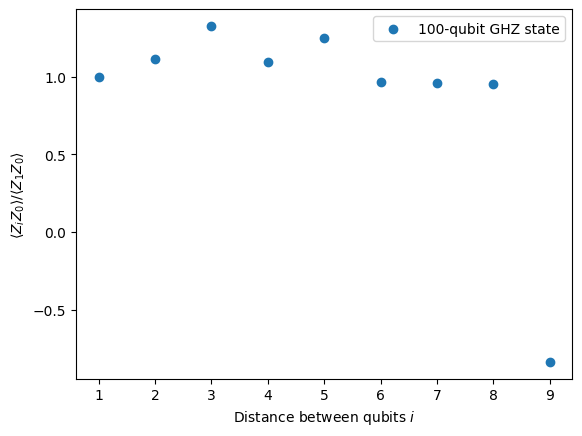

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $')
plt.legend()
plt.show()